In [2]:
import pandas
from janome.tokenizer import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
TEST_SIZE = 0.2
objectiv_col = "isFake"
#トレーニングデータと検証用のテストデータに分割
def split_data_frame(df:pandas.DataFrame, objectiv_col:str):
  df_train, df_val =train_test_split(df, test_size=TEST_SIZE, random_state=42)
  train_y = df_train[objectiv_col]
  train_x = df_train.drop(objectiv_col, axis=1)

  val_y = df_val[objectiv_col]
  val_x = df_val.drop(objectiv_col, axis=1)
  return [train_x, train_y, val_x, val_y]

def clean_text(text):
  return text.replace(' ', '').replace('　', '').replace('__BR__', '\n').replace('\xa0', '').replace('\r', '').lstrip('\n')



In [3]:

df_hate_train = pandas.read_csv("hate/train.csv", index_col=0)
df_hate_train.drop("source", axis=1)
df_hate_test = pandas.read_csv("hate/test.csv", index_col=0)
df_hate_test.drop("source", axis=1)
df_hate_train['text'] = df_hate_train['text'].apply(clean_text)
df_hate_test['text'] = df_hate_test['text'].apply(clean_text)

all_texts = list(df_hate_train["text"])
all_texts.extend(list(df_hate_test["text"]))
janome_tokenizer = Tokenizer()
vectorizer = CountVectorizer(tokenizer=lambda text: janome_tokenizer.tokenize(text, wakati=True))
vectorizer.fit(all_texts)

train_x, train_y, val_x, val_y = split_data_frame(df_hate_train, "label")

df_tweet = pandas.read_csv("hate/tweet.csv", index_col=0)
df_tweet['text'] = df_tweet['text'].apply(clean_text)



c:\workspace\NeuroDive\.venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [4]:

train_vectors = vectorizer.transform(train_x['text'])
val_vectors = vectorizer.transform(val_x['text'])
tweet_vectors = vectorizer.transform(df_tweet['text'])

In [5]:
%matplotlib inline

def print_probas(y, probas):
  fpr, tpr, threshold = roc_curve(y, probas[:, 1])
  plt.style.use("fivethirtyeight")
  fig, ax = plt.subplots()
  fig.set_size_inches(4.8, 5)

  ax.step(fpr, tpr, "gray")
  ax.fill_between(fpr, tpr, 0, color="skyblue", alpha=0.8)
  ax.set_xlabel("False Positive Rate")
  ax.set_ylabel("True Positive Rate")
  ax.set_facecolor("xkcd:white")

  print("AUC:" + str(roc_auc_score(y, probas[:, 1])))
  plt.show()

def calculate(model):
  # fit行う
  model.fit(train_vectors, train_y)
  predict(model)

def predict(model):
  print("-----------------------train.csvデータ----------------")
  print("正解率:" + str(accuracy_score(val_y, model.predict(val_vectors))))
  print_probas(val_y, model.predict_proba(val_vectors))
  print("-----------------------tweet.csvデータ----------------")
  print("正解率:" + str(accuracy_score(df_tweet["label"], model.predict(tweet_vectors))))
  print_probas(df_tweet["label"], model.predict_proba(tweet_vectors))


-----------------------train.csvデータ----------------
正解率:0.9505703422053232
AUC:0.9129374641422834


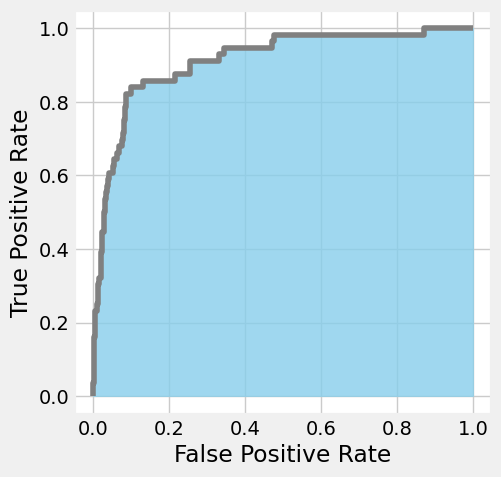

-----------------------tweet.csvデータ----------------
正解率:0.7254901960784313
AUC:0.9015873015873016


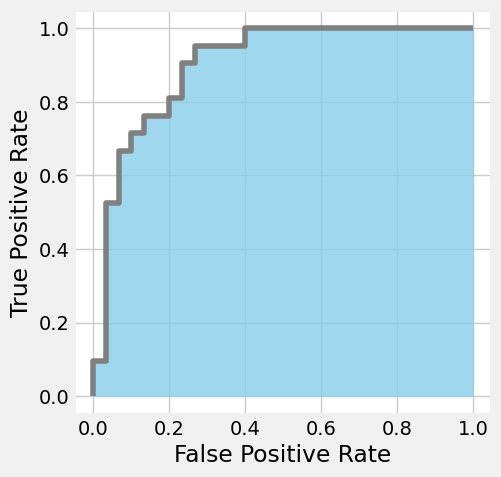

CPU times: total: 125 ms
Wall time: 337 ms


In [6]:
%%time
#ふつうの線形回帰
calculate(LogisticRegression(solver='liblinear'))

-----------------------train.csvデータ----------------
正解率:0.9505703422053232
AUC:0.9106425702811245


c:\workspace\NeuroDive\.venv\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\workspace\NeuroDive\.venv\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\workspace\NeuroDive\.venv\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\workspace\NeuroDive\.venv\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\workspace\NeuroDive\.venv\lib\site-packag

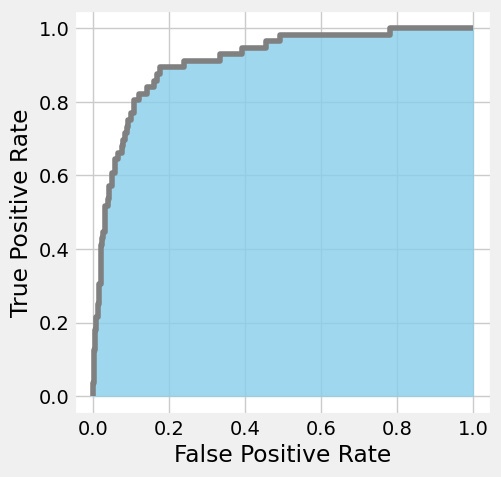

-----------------------tweet.csvデータ----------------
正解率:0.6862745098039216
AUC:0.8841269841269841


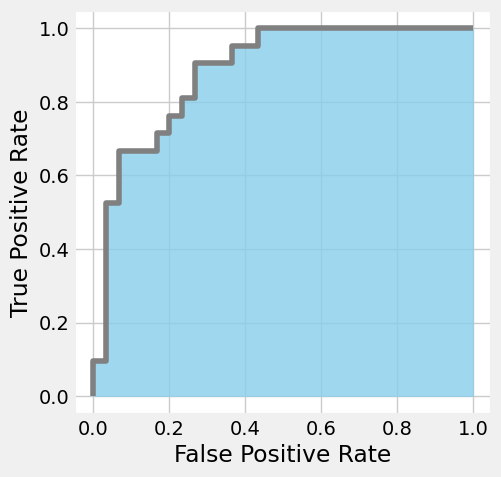

CPU times: total: 172 ms
Wall time: 281 ms


In [7]:
%%time
#サポートベクトルマシン
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
calculate(CalibratedClassifierCV(LinearSVC()) )

-----------------------train.csvデータ----------------
正解率:0.9420152091254753
AUC:0.8415447504302926


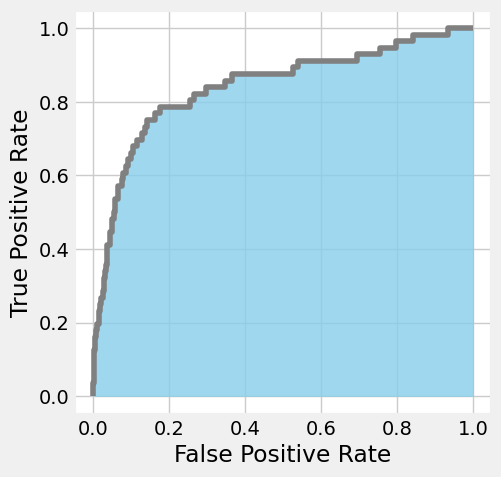

-----------------------tweet.csvデータ----------------
正解率:0.803921568627451
AUC:0.8904761904761905


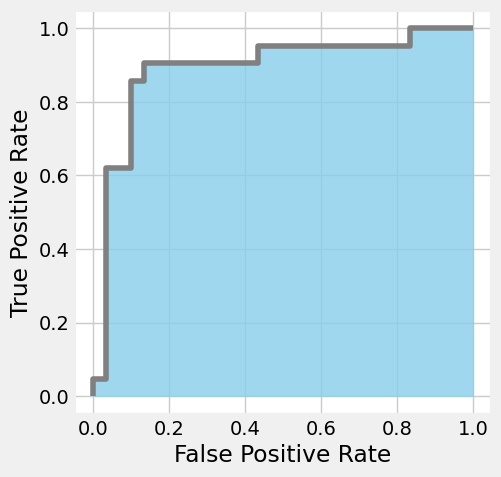

CPU times: total: 4.25 s
Wall time: 16.9 s


In [8]:
%%time
#ニューラルネットワーク
from sklearn.neural_network import MLPClassifier
calculate(MLPClassifier(hidden_layer_sizes=(16,), random_state=42))

-----------------------train.csvデータ----------------
正解率:0.9467680608365019
AUC:0.6322163654618475


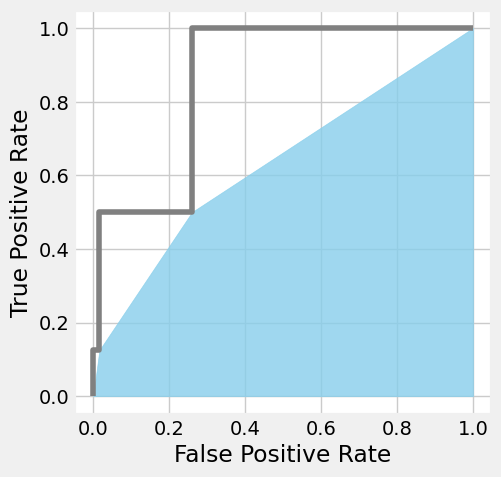

-----------------------tweet.csvデータ----------------
正解率:0.5686274509803921
AUC:0.6944444444444445


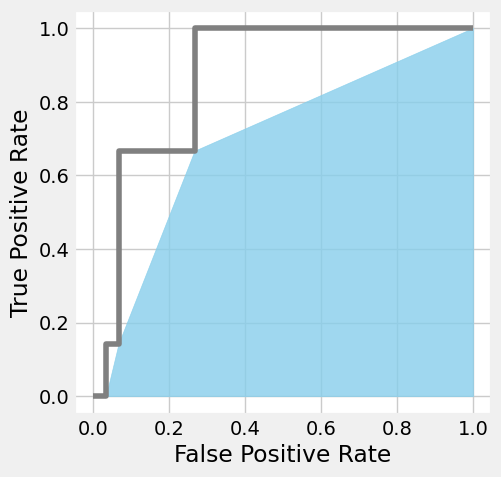

CPU times: total: 422 ms
Wall time: 663 ms


In [9]:
%%time
#ｋ近傍法
from sklearn.neighbors import KNeighborsClassifier
calculate(KNeighborsClassifier())

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

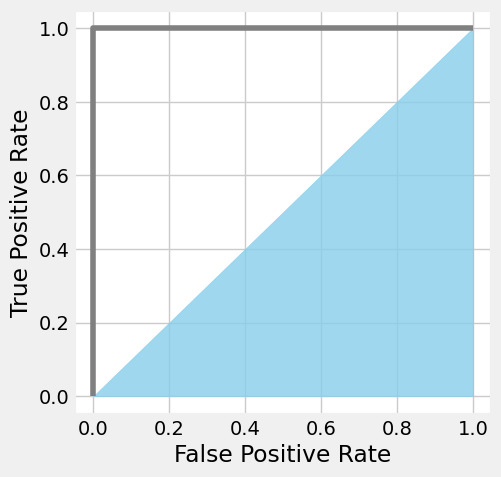

-----------------------tweet.csvデータ----------------
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
正解率:0.6274509803921569
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
AUC:0.5


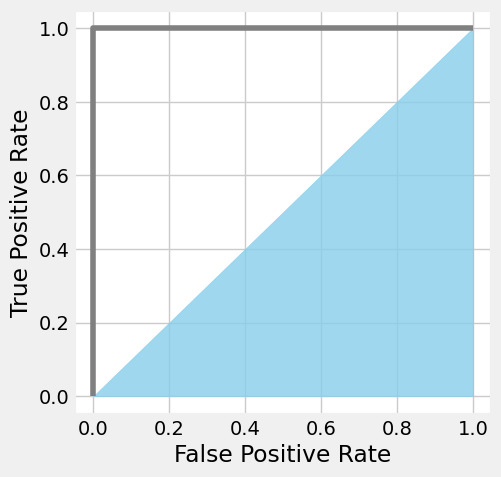

CPU times: total: 797 ms
Wall time: 546 ms


In [10]:
%%time
#lightGBM
import lightgbm as lgb

# モデルの学習
model = lgb.LGBMClassifier(
  objective='binary',
  boosting= 'gbdt', # 'gbdt'はGradient Boosting Decision TreeによるBoosting 
  metric= 'binary_error', 
  num_leaves= 64, 
  min_data_in_leaf= 20, 
  max_depth= 7, 
  verbose= 0, 
)
model.fit(train_vectors.astype("float32"), train_y.astype("float32"))
print("-----------------------train.csvデータ----------------")
print("正解率:" + str(accuracy_score(val_y, model.predict(val_vectors.astype("float32")).astype("int64"))))
print_probas(val_y, model.predict_proba(val_vectors.astype("float32")).astype("int64"))
print("-----------------------tweet.csvデータ----------------")
print("正解率:" + str(accuracy_score(df_tweet["label"], model.predict(tweet_vectors.astype("float32")).astype("int64"))))
print_probas(df_tweet["label"], model.predict_proba(tweet_vectors.astype("float32")).astype("int64"))

# ニューラルネットワークがいいかんじ
- 未検討: xgboost

In [4]:
%%time
# janome
df_hate_train = pandas.read_csv("../data/train.csv", index_col=0)
df_hate_train.drop("source", axis=1)
df_hate_test = pandas.read_csv("../data/test.csv", index_col=0)
df_hate_test.drop("source", axis=1)
df_hate_train['text'] = df_hate_train['text'].apply(clean_text)
df_hate_test['text'] = df_hate_test['text'].apply(clean_text)
df_tweet = pandas.read_csv("../data/tweet.csv", index_col=0)
df_tweet['text'] = df_tweet['text'].apply(clean_text)

train_x, train_y, val_x, val_y = split_data_frame(df_hate_train, "label")

all_texts = list(df_hate_train["text"])
all_texts.extend(list(df_hate_test["text"]))
janome_tokenizer = Tokenizer()
vectorizer = CountVectorizer(tokenizer=lambda text: janome_tokenizer.tokenize(text, wakati=True))
vectorizer.fit(all_texts)
train_vectors = vectorizer.transform(train_x['text'])
val_vectors = vectorizer.transform(val_x['text'])
tweet_vectors = vectorizer.transform(df_tweet['text'])

#ニューラルネットワーク
from sklearn.neural_network import MLPClassifier
calculate(MLPClassifier(hidden_layer_sizes=(16,), random_state=42))

FileNotFoundError: [Errno 2] No such file or directory: 'hate/tweet.csv'

-----------------------train.csvデータ----------------
正解率:0.9420152091254753
AUC:0.5331325301204819


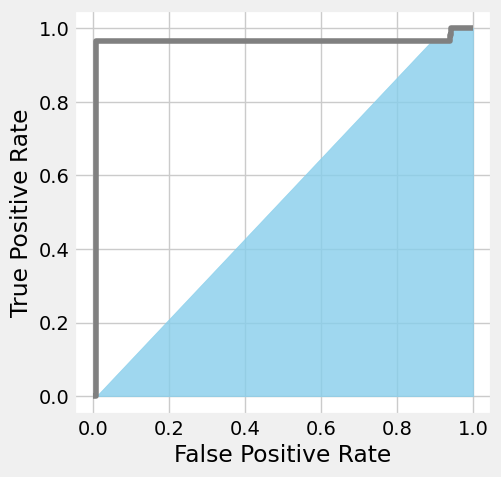

-----------------------tweet.csvデータ----------------
正解率:0.5882352941176471
AUC:0.5166666666666666


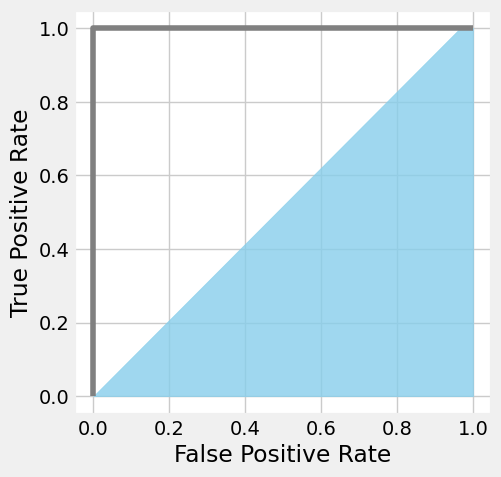

CPU times: total: 922 ms
Wall time: 2.61 s


In [ ]:
%%time
# 特徴エンジニアリング: TF-IDFベクトル化
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000)
vectorizer.fit(all_texts)

train_vectors = vectorizer.transform(train_x['text'])
val_vectors = vectorizer.transform(val_x['text'])
tweet_vectors = vectorizer.transform(df_tweet['text'])

#ニューラルネットワーク
from sklearn.neural_network import MLPClassifier
calculate(MLPClassifier(hidden_layer_sizes=(16,), random_state=42))

In [ ]:
%%time
# bert　CPU不足でエラー出た
# from transformers import BertJapaneseTokenizer, BertModel
# import torch

# class SentenceBertJapanese:
#     def __init__(self, model_name_or_path, device=None):
#         self.tokenizer = BertJapaneseTokenizer.from_pretrained(model_name_or_path)
#         self.model = BertModel.from_pretrained(model_name_or_path)
#         self.model.eval()

#         if device is None:
#             device = "cuda" if torch.cuda.is_available() else "cpu"
#         self.device = torch.device(device)
#         self.model.to(device)

#     def _mean_pooling(self, model_output, attention_mask):
#         token_embeddings = model_output[0] #First element of model_output contains all token embeddings
#         input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#         return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


#     def encode(self, sentences, batch_size=8):
#         all_embeddings = []
#         iterator = range(0, len(sentences), batch_size)
#         for batch_idx in iterator:
#             batch = sentences[batch_idx:batch_idx + batch_size]

#             encoded_input = self.tokenizer.batch_encode_plus(batch, padding="longest", truncation=True, return_tensors="pt").to(self.device)
#             model_output = self.model(**encoded_input)
#             sentence_embeddings = self._mean_pooling(model_output, encoded_input["attention_mask"]).to('cpu')

#             all_embeddings.extend(sentence_embeddings)

#         # return torch.stack(all_embeddings).numpy()
#         return torch.stack(all_embeddings)
    
# MODEL_NAME = "sonoisa/sentence-bert-base-ja-mean-tokens-v2"
# bert = SentenceBertJapanese(MODEL_NAME)

# print("bert model create")

# train_vectors = bert.encode(train_x['text'])
# val_vectors = bert.encode(val_x['text'])
# tweet_vectors = bert.encode(df_tweet['text'])


# print("text vectors create")

# #ニューラルネットワーク
# calculate(MLPClassifier(hidden_layer_sizes=(16,), random_state=42))

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
%%time
## luke
#難点；計算に20hぐらいかかる
import torch
from torch.utils.data import Dataset
from torchinfo import summary
from transformers import (
    AutoTokenizer, Trainer, TrainingArguments,
    LukeTokenizer, LukeForSequenceClassification,
    pipeline
)
from datasets import load_metric
MODEL_NAME = "studio-ousia/luke-japanese-base-lite"
model = LukeForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = 2)


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print("tokenize train")
train_vectors = tokenizer( train_x['text'].tolist(), return_tensors='pt', padding="max_length", truncation=True)
print("tokenize val")
val_vectors   = tokenizer(   val_x['text'].tolist(), return_tensors='pt', padding="max_length", truncation=True)
print("tokenize tweet")
tweet_vectors = tokenizer(df_tweet['text'].tolist(), return_tensors='pt', padding="max_length", truncation=True)

class MyDataset(Dataset):
    """トークン入力データセット"""
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, index):
        input = {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
        if self.labels is not None:
            input["labels"] = torch.tensor(self.labels[index])

        return input

#train/valid/testのデータセットをそれぞれ作成する 
train_ds = MyDataset(train_vectors, train_y.tolist())
val_ds   = MyDataset(val_vectors, val_y.tolist())
tweet_ds = MyDataset(tweet_vectors)

metric_name = "roc_auc"
metric = load_metric(metric_name, trust_remote_code=True)
import numpy

def compute_metrics(pred):

    predictions, labels = pred
    predictions = numpy.argmax(predictions, axis=1)

    # 'micro', 'macro', etc. are for multi-label classification. If you are running a binary classification, leave it as default or specify "binary" for average
    roc_auc = metric.compute(prediction_scores=predictions, references=labels, average="binary")
    return {
        "accuracy": accuracy_score(labels, preds),
        "roc_auc": roc_auc["roc_auc"]
    }

train_args = TrainingArguments(
    output_dir='luke_log',
    overwrite_output_dir        = False, #logを上書きするか
    load_best_model_at_end      = True, #EarlyStoppingを使用するならTrue
    metric_for_best_model       = metric_name, #EarlyStoppingの判断基準。7-1. compute_metricsのものを指定
    save_total_limit            = 1, #output_dirに残すチェックポイントの数
    save_strategy               = "epoch", #いつ保存するか？
    evaluation_strategy         = "epoch", #いつ評価するか？
    logging_strategy            = "epoch", #いつLOGに残すか？
    label_names                 = ['labels'], #分類ラベルのkey名称(デフォルトはlabelsなので注意)
    lr_scheduler_type           = "linear", #学習率の減衰設定(デフォルトlinearなので設定不要)
    learning_rate               = 5e-5, #学習率(デフォルトは5e-5)
    num_train_epochs            = 3, #epoch数
    per_device_train_batch_size = 16, #学習のバッチサイズ
    per_device_eval_batch_size  = 12, #バリデーション/テストのバッチサイズ
    seed                        = 42, #seed
)
trainer = Trainer(
    model=model, #モデル
    args=train_args, #TrainingArguments
    tokenizer=tokenizer, #tokenizer
    train_dataset=train_ds, #学習データセット
    eval_dataset=val_ds, #validデータセット
    compute_metrics = compute_metrics, #compute_metrics
)

trainer.train()

#trainer.predictで評価可能
print("predict")
print("正解率:" + str(accuracy_score(df_tweet["label"], trainer.predict(tweet_ds))))

c:\workspace\NeuroDive\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of LukeForSequenceClassification were not initialized from the model checkpoint at studio-ousia/luke-japanese-base-lite and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenize train


NameError: name 'train_x' is not defined